### Черненко Сергей Евгеньевич (184-321)

# Мультиклассовая классификация с помощью метода опорных векторов

Содержание практической работы:

- функция потерь для метода опорных векторов
- аналитический градиент
- его проверка с помощью численного градиента
- подбор скорости обучения и степени регуляризации на проверочной выборке
- оптимизация функции потерь с помощью стохастического градиентного спуска
- визуализация конечных весов

In [32]:
# Подключим основные библиотеки
from __future__ import print_function

import math
import random
import time
from builtins import object, range

import matplotlib.pyplot as plt
import numpy as np
from past.builtins import xrange

%matplotlib inline

## Загрузка базы CIFAR-10

In [33]:
#Загружаем изображения cifar10
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#X_train - обучающая выборка 
#X_ty_trainrain - желаемая обучающая выборка
#X_test - тестовая выборка
#y_test -  желаемая тестовая выборка

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train=[int(i) for i in y_train]
y_train=np.array(y_train)
y_test=[int(i) for i in y_test]
y_test=np.array(y_test)

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность классов для обучения: ', y_train.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность классов для тестирования: ', y_test.shape)

Размерность изображений для обучения:  (50000, 32, 32, 3)
Размерность классов для обучения:  (50000,)
Размерность изображений для тестирования:  (10000, 32, 32, 3)
Размерность классов для тестирования:  (10000,)


## Визуализация классов и примеров

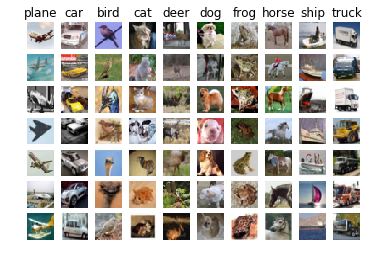

In [34]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Напишите комментарии к коду ниже, что он делает и для чего это нужно.

In [35]:
# Колличество обучающих, валидационных, тестовых и вроверочных изображений

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# mask - это индексы от 49000 до 50000
# X_val и y_val - это массив изображений с индексами mask
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]


# mask - это индексы от 0 до 49000
# X_train и y_train - это массив изображений с индексами mask
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]


# mask - 500 рандомных индексов 
# X_dev и y_dev - это массив изображений с индексами mask
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


# mask - это индексы от 0 до 1000
# X_test и y_test - это массив изображений с индексами mask
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность классов для обучения: ', y_train.shape)
print('Размерность изображений для проверки: ', X_val.shape)
print('Размерность классов для проверки: ', y_val.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность классов для тестирования: ', y_test.shape)

Размерность изображений для обучения:  (49000, 32, 32, 3)
Размерность классов для обучения:  (49000,)
Размерность изображений для проверки:  (1000, 32, 32, 3)
Размерность классов для проверки:  (1000,)
Размерность изображений для тестирования:  (1000, 32, 32, 3)
Размерность классов для тестирования:  (1000,)


In [36]:
# Переводим картинки из формата (32 х 32) в формат (3072)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность изображений для проверки: ', X_val.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность изображений для разрабоки: ', X_dev.shape)

Размерность изображений для обучения:  (49000, 3072)
Размерность изображений для проверки:  (1000, 3072)
Размерность изображений для тестирования:  (1000, 3072)
Размерность изображений для разрабоки:  (500, 3072)


## Первичная обработка данных

In [37]:
# Нормализация данных: вычитаем среднее арифметическое изображение
mean_image = np.mean(X_train, axis = 0)
mean_image=mean_image.astype('uint8')
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Добавление смещения и преобразование в столбцы
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM классификатор

In [38]:
def svm_loss_naive(W, X, y, reg):
    
    dW = np.zeros(W.shape)
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score
            if margin > 0:
                loss += margin
                dW[:,j] += X[i]
                dW[:,y[i]] -= X[i]

    loss /= num_train
    loss += reg * np.sum(W * W)
    
    dW /= num_train
    dW += reg * W
       
    return loss, dW

In [39]:
#Функция для проверки градиента

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([random.randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h
        fxph = f(x)
        x[ix] = oldval - h
        fxmh = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('Численный: %f аналитический: %f, относительная погрешность: %e'
              %(grad_numerical, grad_analytic, rel_error))

In [40]:
# Инициализация весов
W = np.random.randn(3073, 10) * 0.0001

# Расчет потерь и градиента
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Численно рассчитайте градиент по нескольким случайно выбранным измерениям и сравните их с аналитическим градиентом.
# Значения должны быть практически идентичны по любому из измерений.
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Еще раз, но уже с регуляризацией
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Численный: -9.824404 аналитический: -9.800000, относительная погрешность: 1.243529e-03
Численный: 15.602000 аналитический: 15.602000, относительная погрешность: 5.226545e-12
Численный: -5.646000 аналитический: -5.646000, относительная погрешность: 3.180830e-13
Численный: 15.732000 аналитический: 15.732000, относительная погрешность: 3.227579e-12
Численный: 25.234000 аналитический: 25.234000, относительная погрешность: 1.835207e-12
Численный: -10.210530 аналитический: -10.248000, относительная погрешность: 1.831494e-03
Численный: 4.566821 аналитический: 4.440000, относительная погрешность: 1.408050e-02
Численный: -15.662015 аналитический: -15.510000, относительная погрешность: 4.876647e-03
Численный: 5.449270 аналитический: 5.410000, относительная погрешность: 3.616307e-03
Численный: 9.476588 аналитический: 9.372000, относительная погрешность: 5.548840e-03
Численный: -6.185313 аналитический: -6.177657, относительная погрешность: 6.193206e-04
Численный: 10.856648 аналитический: 10.849324

In [41]:
def svm_loss_vectorized(W, X, y, reg):
    
    loss = 0.0
    delta = 1.0
    dW = np.zeros(W.shape) # инициализация градиента равного 0

    # Задание: Реализовать расчет потерь для метода опорных векторов со структурированным результатом.
    # Результат сохранить в loss.

    # ***Начало вашего кода***

    scores = np.dot(X, W)
    correct_class_score = (scores[np.arange(0, scores.shape[0]),y] * np.ones(scores.shape).T).T
    margins_mat = scores - correct_class_score + delta    
    margins_mat = np.maximum(0, margins_mat)
    margins_mat[np.arange(0, scores.shape[0]),y] = 0 
    loss = np.sum(margins_mat) / X.shape[1]
    loss += reg * np.sum(W * W)
    
    #***Конец вашего кода***

    # Задание: Реализовать расчет градиента функции потерь для метода опорных векторов со структурированным результатом.
    # Результат сохранить в dW.
    # Подсказка: чтобы не считать градиент с нуля, следует использовать значения, которые получаются по расчете потерь.

    # ***Начало вашего кода***
        
    margins_mat[margins_mat > 0] = 1
    margins_mat[np.arange(0, scores.shape[0]),y] = 0 
    margins_mat[np.arange(0, scores.shape[0]),y] = -1 * np.sum(margins_mat, axis=1)
    dW = np.dot(X.T,margins_mat) / X.shape[1]

    # ***Конец вашего кода***

    return loss, dW

In [42]:
# Рассчитаем потери и сравним время.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери: %e рассчитаны за %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери векторизованные: %e рассчитаны за %fs' % (loss_vectorized, toc - tic))

print('Разница: %f' % (loss_naive - loss_vectorized))

Потери: 1.680879e+00 рассчитаны за 0.135427s
Потери векторизованные: 1.503734e+00 рассчитаны за 0.008000s
Разница: 0.177145


### Класс — линейный классификатор

Данный код понадобится также и для следующего задания. Сейчас мы создадим подкласс, где потери рассчитываются по SVM, а в следующем будет Softmax.

In [43]:
class LinearClassifier(object):

    def __init__(self):
        
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучения линейного классификатора с использованием стохастического градиентного спуска.
        
        Ввод 
        
        - X: Массив numpy размерности (N, D) содержащий данные для обучения;
        - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
        - learning_rate: (float) скорость обучения для оптимизации.
        - reg: (float) степень регуляризации.
        - num_iters: (integer) количество иттераций обучения
        - batch_size: (integer) количество элементов для обучения на каждом шаге оптимизации.
        - verbose: (boolean) если истина, выводить прогресс во время оптимизации.

        Вывод:
        Список содержащий значение потерь в каждой иттерации обучения.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None:
            # Инициализируем W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Используем стохастический градиентный спуск для оптимизации W.
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

        # Задание: взять подвыборку размером batch_size из данных для обучения и их классы
        # для использования в этом шаге градиентного спуска.
        # Храните данные в X_batch, а их соответствующие классы в y_batch.
        # Можете использовать np.random.choice для генерации индексов.

            # ***Начало вашего кода***

            index = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[index]
            y_batch = y[index]

            # ***Конец вашего кода***

            # Оцениваем потери и градиент
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Обновляем веса

        # Задание: Обновить веса используя градиент и скорость обучения.

            # ***Начало вашего кода***

            self.W += -learning_rate * grad
            
            # ***Конец вашего кода***

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Используя веса после обучения линейного классификатора, предсказать классы для данных X.

        Ввод:
        - X: Массив numpy размерности (N, D) содержащий данные.

        Вывод:
        - y_pred: Предсказанные классы для данных в X.
        y_pred одномерный массив длинной N и каждый элемент это целое число предсказанного класса.
        """
        y_pred = np.zeros(X.shape[0])
        
        # Задание: Реализовать метод предсказания классов, используя полученные при обучении веса.
        # Предсказаные классы записать в y_pred.
        
        # ***Начало вашего кода***

        y_pred = np.argmax(X.dot(self.W),1)
        
        # ***Конец вашего кода***
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        pass


class LinearSVM(LinearClassifier):

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [44]:
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 766.825566
iteration 100 / 1500: loss 765.937874
iteration 200 / 1500: loss 765.429176
iteration 300 / 1500: loss 765.046599
iteration 400 / 1500: loss 764.419328
iteration 500 / 1500: loss 764.055138
iteration 600 / 1500: loss 763.705203
iteration 700 / 1500: loss 763.606256
iteration 800 / 1500: loss 763.059522
iteration 900 / 1500: loss 762.852236
iteration 1000 / 1500: loss 762.531031
iteration 1100 / 1500: loss 762.244347
iteration 1200 / 1500: loss 762.085771
iteration 1300 / 1500: loss 761.796505
iteration 1400 / 1500: loss 761.464073


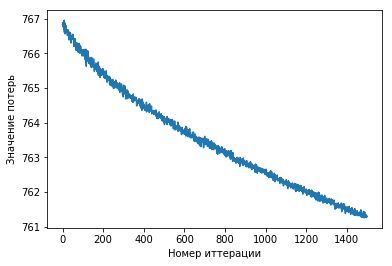

In [45]:
# Построим график потерь от номера иттерации.
plt.plot(loss_hist)
plt.xlabel('Номер иттерации')
plt.ylabel('Значение потерь')
plt.show()

In [46]:
y_train_pred = svm.predict(X_train)
print('Точность при обучении: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('Точность при проверке: %f' % (np.mean(y_val == y_val_pred), ))

Точность при обучении: 0.189408
Точность при проверке: 0.199000


### Перекрестная проверка

Используйте проверочную выборку для корректировки гиперпараметров (степень решуляризации и скорость обучения). Вы должны поэксперементировать с разными диапазонами этих гиперпараметров. Можно добится точности классификации в 0,39 на проверочной выборке.

In [47]:
# Могут возникать ошибки runtime/overflow во время поиска гиперпараметров.
# Причина в экстремальных значениях и это не ошибка в коде.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# результат это словарь связывающий кортежи (learning_rate, regularization_strength)
# с картежами (training_accuracy, validation_accuracy).
# Точность это доля верно классифицированных изображений.
results = {}
best_val = -1   # Наивысшая точность на данный момент.
best_svm = None # Классификатор с наивысшей точностью.


# Задание: Напишите код, который подбирает лучшие значения гиперпараметров, корректируя их на проверочной выборке.
# Для каждой комбинации гиперпараметров обучите классификатор на обучающей выборке,
# рассчитайте его точность на обучающей и проверочной выборках и сохраните результаты в словаре.
# Кроме того, наивысшая точность для проверочной выборки сохраняется в Best_val, а полученный классификатор в best_svm.
# Выбирайте небольшие значения для num_iters чтобы обучение не занимало слишком много времени.
# Увеличивайте его когда уверены в правильности работы кода.

# ***Начало вашего кода***

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train_pred ==y_train)
        val_accuracy = np.mean(y_val_pred == y_val)
        results[(learning_rate, reg)] = train_accuracy, val_accuracy
        if val_accuracy >= best_val:
            best_lr = learning_rate
            best_val = val_accuracy
            best_svm = svm
    

# ***Конец вашего кода***
    
# Выведем полученные результаты.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('Скорость обучения %e степень регуляризации %e точность при обучении: %f точность при проверке: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Лучшая точность на проверочной выборке при перекрестной проверке: %f' % best_val)

Скорость обучения 1.000000e-07 степень регуляризации 2.500000e+04 точность при обучении: 0.204878 точность при проверке: 0.199000
Скорость обучения 1.000000e-07 степень регуляризации 5.000000e+04 точность при обучении: 0.215041 точность при проверке: 0.220000
Скорость обучения 5.000000e-05 степень регуляризации 2.500000e+04 точность при обучении: 0.313816 точность при проверке: 0.296000
Скорость обучения 5.000000e-05 степень регуляризации 5.000000e+04 точность при обучении: 0.332367 точность при проверке: 0.305000
Лучшая точность на проверочной выборке при перекрестной проверке: 0.305000


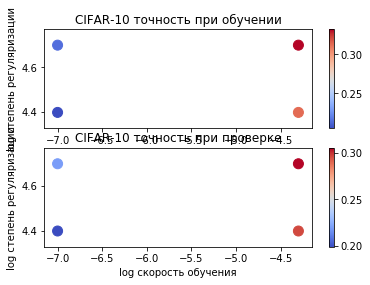

In [48]:
# Визуализируем результаты перекрестной проверки
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Построим график точности на обучающей выборке
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log скорость обучения')
plt.ylabel('log степень регуляризации')
plt.title('CIFAR-10 точность при обучении')

# Построим график точности на проверочной выборке
colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log скорость обучения')
plt.ylabel('log степень регуляризации')
plt.title('CIFAR-10 точность при проверке')
plt.show()

In [49]:
# Оценим лучшую модель на тестовой выборке.
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Точность на тестовой выборке: %f' % test_accuracy)

Точность на тестовой выборке: 0.326000


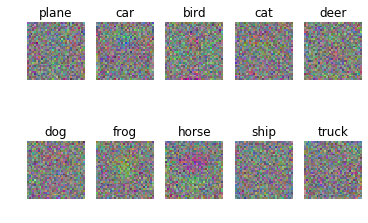

In [50]:
# Визуализируем веса после обучения для каждого класса.
w = best_svm.W[:-1,:]
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])